In [ ]:
# ── A. Imports & Reproducibility ────────────────────────────────────────────────
import os, copy
import csv                                                  # For result logging :contentReference[oaicite:0]{index=0}
import random                                               # For seeding :contentReference[oaicite:1]{index=1}
import numpy as np                                          # For numeric ops :contentReference[oaicite:2]{index=2}
import torch                                               # Core PyTorch :contentReference[oaicite:3]{index=3}
import torch.nn as nn                                       # Neural-net modules :contentReference[oaicite:4]{index=4}
import torch.nn.functional as F                             # Functional API :contentReference[oaicite:5]{index=5}
import torch.optim as optim                                 # Optimizers :contentReference[oaicite:6]{index=6}
from torch.optim.lr_scheduler import CosineAnnealingLR      # Scheduler :contentReference[oaicite:7]{index=7}
from torch.utils.data import DataLoader, random_split       # Data loaders & splits :contentReference[oaicite:8]{index=8}
import torchvision                                          # Datasets & transforms :contentReference[oaicite:9]{index=9}
import torchvision.transforms as T                          # Transforms :contentReference[oaicite:10]{index=10}
from torch.utils.tensorboard import SummaryWriter           # TensorBoard logging :contentReference[oaicite:11]{index=11}
import matplotlib.pyplot as plt                             # Plotting :contentReference[oaicite:12]{index=12}

In [ ]:
# Seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ── B. Device ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")                             # Confirm GPU vs CPU :contentReference[oaicite:13]{index=13}



# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms
transform_train = T.Compose([
    T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])


Using device: cpu


In [ ]:
import glob, torch, os

def latest_ckpt(dirpath, pattern=None):
    """
    If you pass pattern=None, we'll look for anything matching
    *_last_ckpt_round_*.pth and return the numerically latest file.
    """
    if pattern is None:
        pattern = "*_last_ckpt_round_*.pth"
    paths = glob.glob(os.path.join(dirpath, pattern))
    if not paths:
        return None
    # Extract the round number from each filename, assuming it ends in _<round>.pth
    def round_num(p):
        base = os.path.basename(p)
        # splits on underscores: shard_J{J}_last_ckpt_round_{rnd}.pth
        return int(base.rsplit("_",1)[1].split(".")[0])
    paths.sort(key=round_num)
    return paths[-1]


def load_checkpoint(model, optimizer, ckpt_dir, shard_key, J, resume=True):
    if not resume:
        return 1
    pat = f"{shard_key}_J{J}_last_ckpt_round_*.pth"
    ckpt_path = latest_ckpt(ckpt_dir, pat)
    if ckpt_path is None:
        return 1
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    rng_state = ckpt['rng_state']
    if rng_state.device.type != 'cpu':
        rng_state = rng_state.cpu()
    torch.set_rng_state(rng_state)
    print(f"{run_id}")
    server_velocity = torch.load(os.path.join(CKPT_DIR, f"{run_id}_server_velocity.pt"))
    return ckpt['round'] + 1



def save_checkpoint(model, optimizer, round_num, ckpt_dir,
                    shard_key, J, is_best=False):
    """
    Saves:
      <shard_key>_J<J>_last_ckpt_round_<round_num>.pth
    and if is_best=True, also
      <shard_key>_J<J>_best_ckpt.pth
    """
    prefix = f"{shard_key}_J{J}"
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    # unique filename per config
    last_name = f"{prefix}_last_ckpt_round_{round_num}.pth"
    torch.save(state, os.path.join(ckpt_dir, last_name))
    if is_best:
        best_name = f"{prefix}_best_ckpt.pth"
        torch.save(model.state_dict(), os.path.join(ckpt_dir, best_name))
    torch.save(server_velocity, os.path.join(CKPT_DIR, f"{run_id}_server_velocity.pt"))
    print(f"[Checkpoint] Saved {last_name}")



In [ ]:
# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms (as before)…

# Download full CIFAR‑100 training set
full_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# 1) Centralized validation split
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# ── C.1 Build validation loader ───────────────────────────────
BS_VAL = 256
val_loader = DataLoader(
    val_dataset,
    batch_size=BS_VAL,
    shuffle=False,
    num_workers=2
)

# Ensure test_loader exists (fix NameError from summarize_run)
if 'test_loader' not in globals():
    print("Defining test_loader (was missing).")
    # require transform_test and BS_VAL to be defined
    if 'transform_test' not in globals():
        # fallback: define a default transform (shouldn't happen if you defined it earlier)
        transform_test = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
        ])
    test_dataset = torchvision.datasets.CIFAR100(
        './data', train=False, download=True, transform=transform_test
    )
    test_loader = DataLoader(test_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)
else:
    print("test_loader already defined in scope.")

# ── C.2 Non-IID Sharding Helper ────────────────────────────────────────────────

from collections import defaultdict, deque
from torch.utils.data import Subset

def create_labelwise_shards(dataset, K, Nc, seed=42):
    # 1) Group indices by label
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)

    # 2) Shuffle each label’s pool
    rng = random.Random(seed)
    for lbl in label2idx:
        rng.shuffle(label2idx[lbl])

    # 3) Prepare an iterator per label
    pointers = {lbl: 0 for lbl in label2idx}

    # 4) Build shards
    samples_per_client = len(dataset) // K
    shards_idx = []
    labels_cycle = list(label2idx.keys())

    for client_id in range(K):
        client_idxs = []
        # Rotate start point so clients don’t always pick the same first label
        rng.shuffle(labels_cycle)
        for lbl in labels_cycle:
            if len(client_idxs) >= samples_per_client:
                break
            # How many to take from this label
            needed = samples_per_client - len(client_idxs)
            available = len(label2idx[lbl]) - pointers[lbl]
            take = min(needed, available)
            if take > 0:
                start = pointers[lbl]
                end   = start + take
                client_idxs.extend(label2idx[lbl][start:end])
                pointers[lbl] += take
        # If we still haven’t reached samples_per_client (rare), fill randomly
        if len(client_idxs) < samples_per_client:
            all_remaining = [i for lbl in label2idx
                                 for i in label2idx[lbl][pointers[lbl]:]]
            client_idxs.extend(rng.sample(all_remaining,
                                          samples_per_client - len(client_idxs)))
        shards_idx.append(client_idxs)

    return [Subset(dataset, idxs) for idxs in shards_idx]


#NEW OUR CONTRIBUTION

# ── C.2 New: Non-IID shards with a random number of classes per client ─────────
from collections import defaultdict
from torch.utils.data import Subset

def create_labelwise_shards_sampled(dataset, K,
                                    min_classes=1, max_classes=50,
                                    sampler='uniform', poisson_lambda=5,
                                    allocation='equal', dirichlet_alpha=1.0,
                                    seed=42):
    """
    Build K disjoint subsets where each client:
      - samples n_classes ~ (uniform[min,max] OR 1+Poisson(lambda))
      - selects those classes (without replacement)
      - receives `target` examples distributed among the chosen classes
        according to `allocation` (equal or dirichlet proportions)
    Guarantees: no example is duplicated across clients and every example assigned.

    Args:
      dataset: torch Dataset (train_dataset)
      K: number of clients
      min_classes, max_classes: bounds for sampled number of classes per client
      sampler: 'uniform' or 'poisson'
      poisson_lambda: lambda for Poisson sampler
      allocation: 'equal' | 'dirichlet' | 'random' (random proportional)
      dirichlet_alpha: alpha parameter for Dirichlet (if allocation == 'dirichlet')
      seed: RNG seed for reproducibility

    Returns:
      list_of_subsets: list of torch.utils.data.Subset objects length K
    """
    # --- Build per-label index pools (deques for efficient popleft) ---
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)
    # shuffle each label's pool reproducibly
    rng_py = random.Random(seed)
    for lbl in label2idx:
        rng_py.shuffle(label2idx[lbl])
    label_deques = {lbl: deque(label2idx[lbl]) for lbl in label2idx}
    labels = list(label_deques.keys())
    n_labels_total = len(labels)

    # --- compute per-client target sizes (balanced remainder) ---
    N = len(dataset)
    base = N // K
    remainder = N % K
    target_sizes = [base + (1 if i < remainder else 0) for i in range(K)]

    # helper: sample number of classes
    def sample_n_classes_local():
        if sampler == 'uniform':
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))
        elif sampler == 'poisson':
            # use numpy's generator seeded with rng_py for reproducibility
            seed_local = rng_py.randint(0, 2**31 - 1)
            n = int(np.random.default_rng(seed_local).poisson(lam=poisson_lambda)) + 1
            return max(min_classes, min(n, min(max_classes, n_labels_total)))
        else:
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))

    # helper: allocate counts across chosen classes given target and allocation scheme
    def allocate_counts(target, n_chosen):
        if n_chosen <= 0:
            return []
        if allocation == 'equal':
            base_share = target // n_chosen
            rem = target % n_chosen
            alloc = [base_share + (1 if i < rem else 0) for i in range(n_chosen)]
            return alloc
        elif allocation == 'dirichlet':
            # sample proportions from Dirichlet(alpha)
            alpha = np.ones(n_chosen) * float(dirichlet_alpha)
            prop = np.random.default_rng(rng_py.randint(0, 2**31-1)).dirichlet(alpha)
            raw = prop * target
            # convert to integer allocation preserving sum==target
            floored = np.floor(raw).astype(int).tolist()
            leftover = target - sum(floored)
            # distribute leftover to largest fractional parts
            fracs = raw - np.floor(raw)
            order = np.argsort(fracs)[::-1]
            for j in range(leftover):
                floored[order[j]] += 1
            return floored
        else:  # 'random' : choose random integer splits (via multinomial)
            rng_seed = rng_py.randint(0, 2**31 - 1)
            props = np.random.default_rng(rng_seed).multinomial(target, [1.0 / n_chosen] * n_chosen)
            return props.tolist()

    # Prepare result list and a randomized client order to mitigate ordering bias
    client_indices = [[] for _ in range(K)]
    client_order = list(range(K))
    rng_py.shuffle(client_order)  # process clients in random order (deterministic from seed)

    # For speed: keep a small lookup of remaining counts per label
    remaining_per_label = {lbl: len(label_deques[lbl]) for lbl in labels}

    for client_id in client_order:
        target = target_sizes[client_id]
        # sample how many classes this client *wants*
        n_classes = sample_n_classes_local()
        n_classes = min(n_classes, n_labels_total)  # safety

        # choose the classes for this client (without replacement)
        # but prefer classes that still have remaining samples: sample from labels weighted by availability
        available_labels = [lbl for lbl in labels if remaining_per_label.get(lbl, 0) > 0]
        if len(available_labels) == 0:
            # no remaining samples anywhere — extremely unlikely
            break

        # If available_labels < n_classes, we will only choose those available; rest will be filled later.
        if len(available_labels) <= n_classes:
            chosen_labels = available_labels[:]
            rng_py.shuffle(chosen_labels)
        else:
            # sample without replacement among available labels
            # use rng_py.sample for reproducibility
            chosen_labels = rng_py.sample(available_labels, k=n_classes)

        # compute desired allocation across chosen_labels
        alloc = allocate_counts(target, len(chosen_labels))

        # Try to fulfill allocation from chosen labels, consuming their deques
        client_taken = []
        shortfall = 0
        for lbl, want in zip(chosen_labels, alloc):
            available = remaining_per_label.get(lbl, 0)
            take = min(want, available)
            for _ in range(take):
                client_taken.append(label_deques[lbl].popleft())
            remaining_per_label[lbl] = remaining_per_label.get(lbl, 0) - take
            if take < want:
                shortfall += (want - take)

        # If there is a shortfall, try to fill it from other labels (scan labels by remaining)
        if shortfall > 0:
            # build a list of labels sorted by remaining count (descending) to fill quickly
            refill_labels = sorted(labels, key=lambda x: remaining_per_label.get(x, 0), reverse=True)
            for lbl in refill_labels:
                if shortfall <= 0:
                    break
                available = remaining_per_label.get(lbl, 0)
                if available <= 0:
                    continue
                take = min(available, shortfall)
                for _ in range(take):
                    client_taken.append(label_deques[lbl].popleft())
                remaining_per_label[lbl] -= take
                shortfall -= take

        # Final safety: if still short (very unlikely), allow sampling from any remaining indices with replacement
        if len(client_taken) < target:
            need = target - len(client_taken)
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) >= need and len(all_remaining) > 0:
                # take deterministically from the front of remaining pools
                # and advance pointers (pop left)
                taken_now = all_remaining[:need]
                # Pop these indices from deques by label
                taken_count = 0
                for lbl in labels:
                    while taken_count < need and len(label_deques[lbl]) > 0:
                        client_taken.append(label_deques[lbl].popleft())
                        remaining_per_label[lbl] -= 1
                        taken_count += 1
                        if taken_count >= need:
                            break
            else:
                # fallback: sample with replacement from full index range (shouldn't be necessary)
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        # Ensure exact target
        if len(client_taken) > target:
            client_taken = client_taken[:target]
        elif len(client_taken) < target:
            # pad (should not happen) with random indices not yet used if possible
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) > 0:
                client_taken += all_remaining[:(target - len(client_taken))]
                # pop them
                taken_rem = target - len(client_taken)
                popped = 0
                for lbl in labels:
                    while popped < taken_rem and len(label_deques[lbl]) > 0:
                        label_deques[lbl].popleft()
                        remaining_per_label[lbl] -= 1
                        popped += 1
                        if popped >= taken_rem:
                            break
            else:
                # absolute last resort: sample from full dataset with replacement
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        client_indices[client_id] = client_taken

    # Final check: every example should be assigned exactly once
    all_assigned = [i for lst in client_indices for i in lst]
    if len(all_assigned) != len(set(all_assigned)):
        # Debug info if something went wrong
        dup_count = len(all_assigned) - len(set(all_assigned))
        print(f"[Warning] {dup_count} duplicates detected in assignment (unexpected).")
    if sum(len(lst) for lst in client_indices) != N:
        # Some items may remain unassigned if remainder was mis-handled; append them to last clients
        remaining = []
        for lbl in labels:
            remaining.extend(list(label_deques[lbl]))
        if remaining:
            # distribute remaining to clients with available capacity
            for idx in remaining:
                # find first client with room
                for cid in range(K):
                    if len(client_indices[cid]) < target_sizes[cid]:
                        client_indices[cid].append(idx)
                        break

    # Convert to Subsets
    subsets = [Subset(dataset, idxs) for idxs in client_indices]
    return subsets

# ── Utility: number of unique classes in a Subset ─────────────────────────────────
def subset_num_classes(subset):
    labs = set()
    # subset is a torch.utils.data.Subset pointing to original dataset
    base_ds = subset.dataset
    for idx in subset.indices:
        _, lbl = base_ds[idx]
        labs.add(lbl)
    return len(labs)








# existing:
K = 100
base = train_size // K
sizes = [base] * (K - 1) + [train_size - base * (K - 1)]
iid_shards = random_split(train_dataset, sizes, generator=torch.Generator().manual_seed(seed))

shardings = {'iid': iid_shards}

# Add old non_iid_Nc variants if you want to keep them
Nc_list = [1, 5, 10, 50]
for Nc in Nc_list:
    shardings[f'non_iid_{Nc}'] = create_labelwise_shards(train_dataset, K, Nc, seed)

# Add new random-classes variants:
shardings['sampled_uniform'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=50,
    sampler='uniform', allocation='equal', seed=42
)

shardings['sampled_poisson'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=20,
    sampler='poisson', poisson_lambda=3, allocation='dirichlet', dirichlet_alpha=0.5, seed=42
)



100%|██████████| 169M/169M [00:02<00:00, 73.6MB/s]


Defining test_loader (was missing).


In [ ]:
# run after creating 'subsets' (e.g. shards = shardings['non_iid_random_uniform_1_50'])
subsets = shardings['sampled_uniform']  # or call the function directly
K_check = len(subsets)
samples_per_client = len(subsets[0].indices)

# 1) same size per client
sizes = [len(s.indices) for s in subsets]
print("sizes: min, max, unique counts:", min(sizes), max(sizes), set(sizes))

# 2) no duplicates across clients and coverage
all_idxs = [i for s in subsets for i in s.indices]
total_assigned = len(all_idxs)
unique_assigned = len(set(all_idxs))
print("total_assigned:", total_assigned, "unique_assigned:", unique_assigned)

if unique_assigned != total_assigned:
    print("WARNING: some indices are duplicated across clients.")
else:
    print("OK: no duplicated indices across clients.")

# 3) full coverage (only true if K * samples_per_client == len(dataset))
N = len(train_dataset)
print("dataset size N:", N, "K*samples_per_client:", K_check * samples_per_client)
if K_check * samples_per_client == N:
    print("OK: every example is assigned exactly once.")
else:
    print("Note: not all examples were assigned (this is expected if N not divisible by K).")

# 4) classes per client distribution
def subset_num_classes(sub):
    base = sub.dataset
    labs = set(base[idx][1] for idx in sub.indices)
    return len(labs)

classes_per_client = [subset_num_classes(s) for s in subsets]
print("classes per client: min, max, mean:", min(classes_per_client), max(classes_per_client), sum(classes_per_client)/len(classes_per_client))


sizes: min, max, unique counts: 450 450 {450}
total_assigned: 45000 unique_assigned: 45000
OK: no duplicated indices across clients.
dataset size N: 45000 K*samples_per_client: 45000
OK: every example is assigned exactly once.
classes per client: min, max, mean: 2 49 24.38


Saved classes_per_client.csv (client_id, unique_classes)


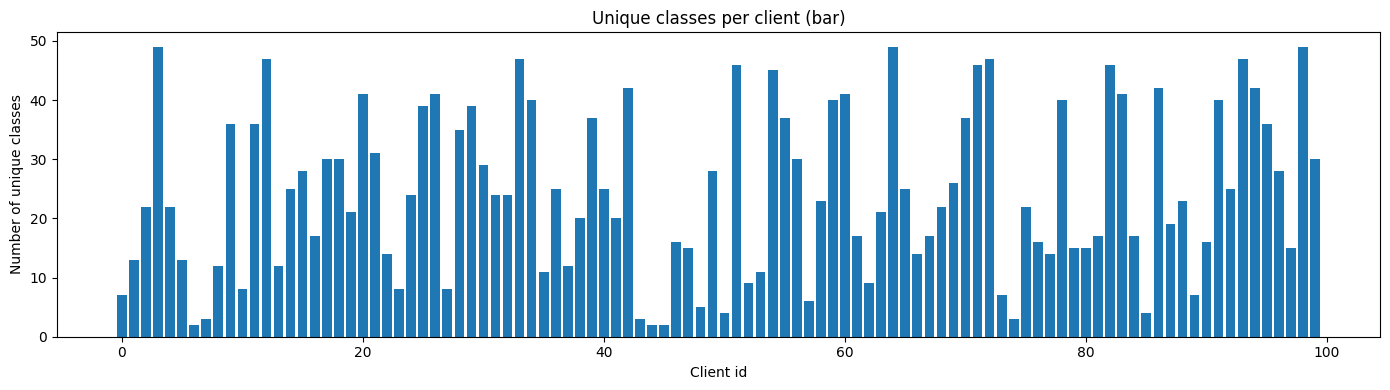

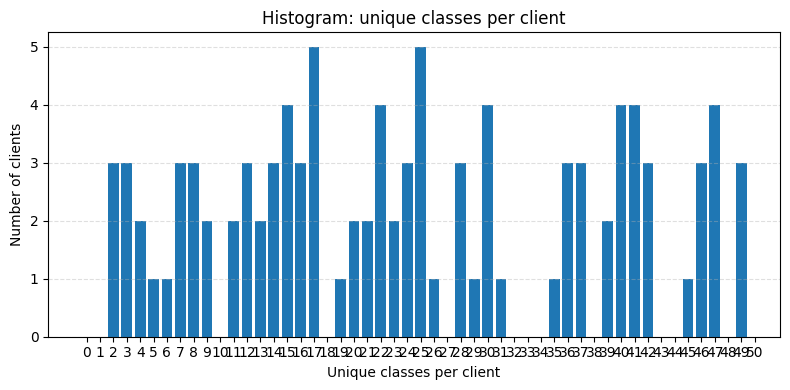

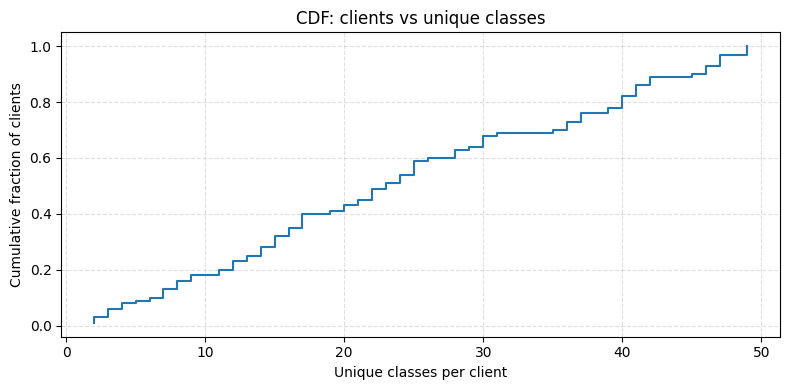

min, max, mean, median, std: 2 49 24.38 23.0 13.898762534844606

Top 10 clients by number of unique classes:
  client_id  unique_classes
         3              49
        64              49
        98              49
        12              47
        93              47
        72              47
        33              47
        71              46
        51              46
        82              46


In [ ]:
# Helper: compute unique classes per subset (client)
import pandas as pd

def subset_num_classes(subset, dataset):
    labs = set(dataset[idx][1] for idx in subset.indices)
    return len(labs)

# Compute
K = len(subsets)
classes_per_client = [subset_num_classes(s, train_dataset) for s in subsets]

# DataFrame for convenience
df = pd.DataFrame({
    'client_id': np.arange(K),
    'unique_classes': classes_per_client
})
df.to_csv("classes_per_client.csv", index=False)
print("Saved classes_per_client.csv (client_id, unique_classes)")

# 1) Bar plot (clients on x)
plt.figure(figsize=(14,4))
plt.bar(df['client_id'], df['unique_classes'])
plt.xlabel("Client id")
plt.ylabel("Number of unique classes")
plt.title("Unique classes per client (bar)")
plt.tight_layout()
plt.savefig("classes_per_client_bar.png")
plt.show()

# 2) Histogram (distribution)
max_classes = max(classes_per_client)
bins = range(0, max_classes+2)  # integer bins
plt.figure(figsize=(8,4))
plt.hist(classes_per_client, bins=bins, align='left', rwidth=0.8)
plt.xticks(bins)
plt.xlabel("Unique classes per client")
plt.ylabel("Number of clients")
plt.title("Histogram: unique classes per client")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("classes_per_client_hist.png")
plt.show()

# 3) CDF (cumulative distribution)
vals_sorted = np.sort(classes_per_client)
cdf = np.arange(1, K+1) / K
plt.figure(figsize=(8,4))
plt.step(vals_sorted, cdf, where='post')
plt.xlabel("Unique classes per client")
plt.ylabel("Cumulative fraction of clients")
plt.title("CDF: clients vs unique classes")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("classes_per_client_cdf.png")
plt.show()

# Quick stats
print("min, max, mean, median, std:", np.min(classes_per_client),
      np.max(classes_per_client), np.mean(classes_per_client),
      np.median(classes_per_client), np.std(classes_per_client))

# Optional: top clients with most classes
top = df.sort_values('unique_classes', ascending=False).head(10)
print("\nTop 10 clients by number of unique classes:\n", top.to_string(index=False))

In [ ]:
# ── D. Model Definition ─────────────────────────────────────────────────────────
class LELeNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*8*8, 384)
        self.fc2   = nn.Linear(384, 192)
        self.fc3   = nn.Linear(192, 100)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# ── E. Utilities: Train/Eval & Checkpointing ────────────────────────────────────
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    return running_loss/total, correct/total


def train_one_epoch_fedprox(model, optimizer, criterion, loader, global_params, mu=0.01, device=device):
    """
    One local epoch with FedProx proximal term:
      loss = CE(out, lbl) + (mu/2) * ||w - w_global||^2
    global_params: dict mapping param-name -> tensor (on CPU or same device)
    """
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)

        # proximal term
        prox = 0.0
        for name, p in model.named_parameters():
            if name in global_params:
                # ensure same device
                g = global_params[name].to(p.device)
                prox += torch.sum((p - g)**2)
        loss = loss + 0.5 * mu * prox

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    if total == 0:
        return 0.0, 0.0
    return running_loss / total, correct / total




def eval_model(model, criterion, loader):
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            correct += out.argmax(1).eq(lbls).sum().item()
            total += lbls.size(0)
    return running_loss/total, correct/total


def sample_clients_dirichlet(K, m, gamma, rng):
    """
    Sample m out of K client indices, with probabilities:
      • uniform if gamma == 'uniform'
      • drawn from Dirichlet([gamma]*K) otherwise.
    Returns:
      selected: list of m client indices
      p:        length-K numpy array of sampling probs (sums to 1)
    """
    if gamma == 'uniform':
        p = np.ones(K) / K
    else:
        alpha = np.ones(K) * gamma
        p     = rng.dirichlet(alpha)
    selected = rng.choice(K, size=m, replace=False, p=p)
    return selected.tolist(), p



In [ ]:
# ── Configuration Summary & Utilities for FedAvg ──────────────────────────────

import os, sys, platform, time
import torch
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter



# 3) Hyperparameters
K, C = 100, 0.1
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 250
budget   = J0 * R0
J_list   = [4, 8, 16]



# 1) Define and instantiate your TensorBoard writer
log_dir = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# 2) Summary utility
def summarize_run(cfg, client_loaders, test_loader, writer=None):
    """
    Print and log summary for a FedAvg run.
    """
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f"\n========== FEDAVG RUN SUMMARY ({ts}) ==========")
    # Hyperparameters
    for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
        print(f"    • {key}: {cfg[key]}")
    # Data info
    num_clients  = len(client_loaders)
    shard_size   = len(client_loaders[0].dataset)
    test_samples = len(test_loader.dataset)
    print(f"    • clients (K): {num_clients}, shard size: {shard_size}")
    print(f"    • test samples: {test_samples}, batch size: {cfg['batch_size']}")
    # Log to TensorBoard
    if writer:
        for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
            writer.add_text(f'RunInfo/{key}', str(cfg[key]), 0)

# 3) Checkpoint utility
ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)


# ── Example Usage ────────────────────────────────────────────────────────────────

cfg = {
    'lr':           LR,
    'weight_decay': WD,
    'batch_size':   BS,
    'K':            K,
    'C':            C,
    'J0':            J0,
    'ROUNDS':       R0

}



In [ ]:
import os, time, uuid, json
import numpy as np, pandas as pd

ARTIFACT_DIR = '/content/drive/MyDrive/fl_results'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ------------- helper: JSON / CSV safe serializer -------------
def _to_json_compatible(v):
    """
    Convert common numpy / torch / python objects into JSON-serializable primitives.
    Returns a Python primitive (int/float/bool/str) or a JSON string for lists/dicts.
    """
    # None
    if v is None:
        return None

    # numpy scalar -> python scalar
    if isinstance(v, (np.integer,)):
        return int(v)
    if isinstance(v, (np.floating,)):
        return float(v)
    if isinstance(v, (np.bool_,)):
        return bool(v)

    # numpy array -> list as JSON string (keeps CSV cell tidy)
    if isinstance(v, np.ndarray):
        try:
            return json.dumps(v.tolist())
        except Exception:
            return json.dumps([_to_json_compatible(x) for x in v.tolist()])

    # list/tuple -> JSON string
    if isinstance(v, (list, tuple)):
        try:
            cleaned = []
            for x in v:
                if isinstance(x, (np.integer,)):
                    cleaned.append(int(x))
                elif isinstance(x, (np.floating,)):
                    cleaned.append(float(x))
                elif isinstance(x, (np.ndarray,)):
                    cleaned.append(x.tolist())
                else:
                    cleaned.append(x)
            return json.dumps(cleaned)
        except Exception:
            return json.dumps([str(x) for x in v])

    # dict -> JSON string
    if isinstance(v, dict):
        try:
            def _conv(obj):
                if isinstance(obj, (np.integer,)):
                    return int(obj)
                if isinstance(obj, (np.floating,)):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                if isinstance(obj, (list, tuple)):
                    return [_conv(x) for x in obj]
                if isinstance(obj, dict):
                    return {str(k): _conv(val) for k, val in obj.items()}
                return obj
            return json.dumps(_conv(v))
        except Exception:
            return json.dumps({str(k): str(vv) for k, vv in v.items()})

    # torch tensors
    try:
        import torch
        if isinstance(v, torch.Tensor):
            try:
                return json.dumps(v.detach().cpu().tolist())
            except Exception:
                return str(v.detach().cpu().tolist())
    except Exception:
        pass

    # Python primitives
    if isinstance(v, (int, float, str, bool)):
        return v

    # fallback -> string
    try:
        return str(v)
    except Exception:
        return None


# ------------- CSV column template -------------
DEFAULT_COLS = [
    'run_id','shard_key','J','C','LR','seed','server_momentum','server_lr',
    'round','wall_time_s',
    'local_mean','local_std',
    'val_loss','val_acc','test_loss','test_acc',
    'probe_min','probe_mean','probe_max',
    'avg_client_delta_norm','max_client_delta_norm','clipped_fraction',
    'candidate_pool_size','selected_client_count','forced_selected_count',
    'selection_count_min','selection_count_mean','selection_count_max','selection_count_median','selection_count_std',
    'selected_ids_json'
]


# ------------- make run id (use before init_round_csv) -------------
def make_run_id(cfg_meta=None):
    t = time.strftime("%Y%m%d-%H%M%S")
    short = ""
    if isinstance(cfg_meta, dict):
        short = f"J{cfg_meta.get('J','?')}_C{cfg_meta.get('C','?')}_LR{cfg_meta.get('LR','?')}_seed{cfg_meta.get('seed','?')}"
    else:
        short = uuid.uuid4().hex[:6]
    return f"{t}_{short}_{uuid.uuid4().hex[:6]}"


# ------------- init_round_csv (create CSV on Drive) -------------
def init_round_csv(run_id, artifact_dir=ARTIFACT_DIR, cols=None):
    """
    Create per-run CSV with header if missing and return its absolute path on Drive.
    """
    if cols is None:
        cols = DEFAULT_COLS
    os.makedirs(artifact_dir, exist_ok=True)
    path = os.path.join(artifact_dir, f"rounds_{run_id}.csv")
    if not os.path.exists(path):
        pd.DataFrame(columns=cols).to_csv(path, index=False)
        print("Created run CSV:", path)
    else:
        print("Run CSV exists:", path)
    return path


# ------------- append_round_csv (append one row safely) -------------
def append_round_csv(path, row_dict, cols=None):
    """
    Append a single row (row_dict) to CSV at `path`. Non-stringable numpy types are converted safely.
    If 'selected_ids_json' isn't provided but 'selected' list is passed, it will serialize that.
    """
    if cols is None:
        try:
            cols = list(pd.read_csv(path, nrows=0).columns)
        except Exception:
            cols = DEFAULT_COLS

    # Build ordered row following columns
    safe_row = {}
    for c in cols:
        if c == 'selected_ids_json':
            # allow caller to pass 'selected' key (list) or already 'selected_ids_json'
            raw = row_dict.get(c, row_dict.get('selected', None))
            if raw is None:
                safe_row[c] = ""
            else:
                safe_row[c] = _to_json_compatible(raw)
            continue

        raw_val = row_dict.get(c, None)
        safe_row[c] = _to_json_compatible(raw_val)

    # Use pandas to append (keeps header stable)
    df = pd.DataFrame([safe_row], columns=cols)
    df.to_csv(path, mode='a', header=False, index=False)


# ------------- save_run_arrays (pickle small objects to Drive) -------------
def save_run_arrays(run_id, arrays, artifact_dir=ARTIFACT_DIR):
    """
    Save arbitrary python objects (lists / dicts / ndarrays) in a pickled file on Drive.
    """
    os.makedirs(artifact_dir, exist_ok=True)
    path = os.path.join(artifact_dir, f"{run_id}_arrays.pkl")
    with open(path, 'wb') as f:
        pickle.dump(arrays, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved arrays to:", path)
    return path



def _safe_serialize(v):
    """
    Convert common numpy / torch / python objects to JSON-serializable or plain python values.
    Returns either a Python int/float/str or a JSON string for lists/dicts.
    """
    # None
    if v is None:
        return None

    # numpy scalar
    if isinstance(v, (np.integer,)):
        return int(v)
    if isinstance(v, (np.floating,)):
        return float(v)
    if isinstance(v, (np.bool_ , )):
        return bool(v)

    # numpy array
    if isinstance(v, np.ndarray):
        # for numeric arrays -> convert to python list
        try:
            return json.dumps(v.tolist())
        except Exception:
            return str(v.tolist())

    # list or tuple -> try to convert inner elements
    if isinstance(v, (list, tuple)):
        try:
            cleaned = [int(x) if (isinstance(x, (np.integer,)) or (isinstance(x, (int,)) and not isinstance(x, bool))) else
                       float(x) if isinstance(x, (np.floating,)) else
                       (x.tolist() if hasattr(x, 'tolist') else x)
                       for x in v]
            return json.dumps(cleaned)
        except Exception:
            # final fallback
            return json.dumps([str(x) for x in v])

    # dict -> JSON
    if isinstance(v, dict):
        # convert keys/values recursively where possible
        def _conv(obj):
            if isinstance(obj, (np.integer,)):
                return int(obj)
            if isinstance(obj, (np.floating,)):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            if isinstance(obj, (list,tuple)):
                return [_conv(x) for x in obj]
            if isinstance(obj, dict):
                return {str(k): _conv(val) for k,val in obj.items()}
            return obj
        try:
            return json.dumps(_conv(v))
        except Exception:
            return json.dumps({str(k):str(vv) for k,vv in v.items()})

    # torch tensors (if present) -> convert to numpy then list
    try:
        import torch
        if isinstance(v, torch.Tensor):
            try:
                return json.dumps(v.detach().cpu().tolist())
            except Exception:
                return str(v.detach().cpu().tolist())
    except Exception:
        pass

    # builtin python primitives (int, float, str, bool)
    if isinstance(v, (int, float, str, bool)):
        return v

    # fallback: stringify
    try:
        return str(v)
    except Exception:
        return None




"""

CSV columns (definitive):

['run_id','shard_key','J','C','LR','seed','server_momentum','server_lr',
 'round','wall_time_s',
 'local_mean','local_std',
 'val_loss','val_acc','test_loss','test_acc',
 'probe_min','probe_mean','probe_max',
 'avg_client_delta_norm','max_client_delta_norm','clipped_fraction',
 'candidate_pool_size','selected_client_count','forced_selected_count',
 'selection_count_min','selection_count_mean','selection_count_max','selection_count_median','selection_count_std',
 'selected_ids_json']






 NPZ keys (definitive):

selected_history, probe_history, selection_count, last_selected_round, shards_info, cfg


4"""

"\n\nCSV columns (definitive):\n\n['run_id','shard_key','J','C','LR','seed','server_momentum','server_lr',\n 'round','wall_time_s',\n 'local_mean','local_std',\n 'val_loss','val_acc','test_loss','test_acc',\n 'probe_min','probe_mean','probe_max',\n 'avg_client_delta_norm','max_client_delta_norm','clipped_fraction',\n 'candidate_pool_size','selected_client_count','forced_selected_count',\n 'selection_count_min','selection_count_mean','selection_count_max','selection_count_median','selection_count_std',\n 'selected_ids_json']\n\n\n\n\n\n\n NPZ keys (definitive):\n\nselected_history, probe_history, selection_count, last_selected_round, shards_info, cfg\n\n\n4"

In [ ]:

# ── A. Mount Google Drive ─────────────────────────────────────────────────────
from google.colab import drive
import os, pickle
import time, uuid, json

MOUNT_POINT = '/content/drive'
DRIVE_MYDRIVE = os.path.join(MOUNT_POINT, 'MyDrive')
if os.path.exists(DRIVE_MYDRIVE):
    print("Google Drive already mounted (detected /content/drive/MyDrive).")
else:
    print("Mounting Google Drive...")
    drive.mount(MOUNT_POINT)
    print("Drive mounted.")

# ------------- Paths and artifact directory on Drive -------------
DRIVE_BASE   = os.path.join('/content/drive', 'MyDrive')
CKPT_DIR     = os.path.join(DRIVE_BASE, 'fl_checkpoints')   # checkpoints
RESULTS_DIR  = os.path.join(DRIVE_BASE, 'fl_results')       # CSVs + arrays

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Checkpoints dir:", CKPT_DIR)
print("Results dir:", RESULTS_DIR)




# Set this to True to resume from the last checkpoint; False to start from scratch
RESUME = True



# 3) Hyperparameters
K, C = 100, 0.2
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 400
budget   = J0 * R0
J_list   = [4]   #[4, 8, 16]



# ── Instantiate TensorBoard writer ──────────────────────────────────────────────
from torch.utils.tensorboard import SummaryWriter
log_dir   = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'



# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'
if not os.path.exists(csv_path):
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'round',
            'val_loss', 'val_acc',
            'test_loss', 'test_acc'
        ])

# Before your FedAvg loop: Instantiate the global model, loss, and client loaders once

rng = np.random.default_rng(seed)


ARTIFACT_DIR = RESULTS_DIR  # keep your existing variable name but point it to fl_results


# ── C. FedAvg Training Loop ─────────────────────────────────────────────────────
# ── F. FedAvg Experiment Loop with Drive Checkpoints ──────────────────────────
# Assumes `shardings`, `J_list`, `budget`, `load_checkpoint`, `save_checkpoint`, etc. are defined

# ── D: Training Loop ────────────────────────────────────────────────────────────
all_results = {}


shard_keys_to_run = ['sampled_uniform']  # or ['non_iid_random_poisson_1_20'], or both

for shard_key in shard_keys_to_run:
    shards = shardings[shard_key]
    client_loaders = [
        DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
        for i in range(K)
    ]

    for J in J_list:
        ROUNDS_scaled = budget // J
        cfg.update({'J': J, 'ROUNDS': ROUNDS_scaled})
        summarize_run(cfg, client_loaders, test_loader, writer=tb_writer)

        # Initialize model & optimizer, then resume if any
        model     = LELeNetCIFAR().to(device)
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
        criterion = nn.CrossEntropyLoss()



                # ---------------- FedAvgM (server momentum) initialization ----------------
        # server_momentum: momentum factor beta (0.0 = no momentum; 0.9 is common)
        server_velocity = {k: torch.zeros_like(v.detach().cpu()) for k, v in model.state_dict().items()}
        # server_lr: scale applied to velocity before adding to global (1.0 typical)
        server_momentum = 0.8   #values to try from 0.99 to 0.8
        server_lr = 1.0   #values to try {1.0, 0.5, 0.2}   (0.5 was poor)


        cfg_meta = {
            'shard_key': shard_key,
            'J': J, 'C': C, 'LR': LR, 'WD': WD,
            'seed': seed if 'seed' in globals() else None,
            'server_momentum': server_momentum, 'server_lr': server_lr,
            'candidate_multiplier': 2, 'probe_batches': 2, 'probe_steps': 1
        }



        #coso run_id make_run_id problematico drive file csv (lunga descrizione per trovarlo con control f)
        run_id = make_run_id(cfg_meta)
        #run_id = "20250831-144952_J4_C0.2_LR0.01_seed42_9b7554"

        start_round = load_checkpoint(
            model, optimizer,
            ckpt_dir=CKPT_DIR,
            shard_key=shard_key, J=J,
            resume=RESUME
        )




        # initialize server_velocity as CPU tensors (persist across rounds)

        # If you resume from a checkpoint and have saved velocity, load it here.
        # (Optional) load server_velocity from disk if you saved it with checkpointing.
        # ----------------------------------------------------------------------------



        # ---- run metadata & persistent artifacts setup ----
        # assume functions init_round_csv, append_round_csv, save_run_arrays are already defined in the notebook


        rounds_csv = init_round_csv(run_id)
        print(f"Run id: {run_id}  -> CSV: {rounds_csv}")
        # --------------------------------------------------





        acc_hist = []
        print(f"[{shard_key}|J={J}] Starting from round {start_round}/{ROUNDS_scaled}")



        # ---- selection/fairness state (persist across rounds) ----
        selection_count = np.zeros(K, dtype=int)         # how many times each client got selected
        last_selected_round = np.full(K, -999999, dtype=int)  # last round index when client was selected
        # Tuneable fairness/selection hyperparams (try these starts)
        beta_fairness = 0.3    # weight of fairness in final score (0.0 = pure probe only; 1.0 = pure fairness)
        temp = 0.7             # softmax temperature for probabilistic explore slot sampling (lower -> peakier)
        max_gap_rounds = int(0.25 * ROUNDS_scaled)  # force select any client not picked for this many rounds
        # ---------------------------------------------------------


        # add BEFORE the rounds loop
        selected_history = []   # list of lists
        probe_history    = []   # list of probe_norm lists


        # -------------------- FedAvg loop with update-norm selection + light exploration --------------------
        for rnd in range(start_round, ROUNDS_scaled + 1):
            round_start = time.time()

            # -------- selection hyperparameters (tuneable) ----------
            m = max(1, int(C * K))
            candidate_multiplier = 2           # probe candidate pool = candidate_multiplier * m
            candidate_pool_size = min(K, max(m, int(candidate_multiplier * m)))
            probe_batches = 2                  # number of minibatches to run during probe (cheap)
            probe_steps = 1                    # number of small probe iterations (keeps small)
            epsilon = 0.05                      # fraction of slots for uniform exploration
            clip_norm = 10.0                   # clip per-client update norm (None to disable)
            reuse_probe_model_if_selected = True  # reuse probed model when a client is selected
            # -------------------------------------------------------

            # Prepare containers
            probe_norms = {}     # cid -> scalar norm from probe
            probe_models = {}    # cid -> state_dict of the probed model (if reusing)
            probe_accs = {}      # cid -> probe accuracy (logging)
            local_states, sizes, local_accuracies = [], [], []

            # Candidate pool (sample uniformly at random)
            candidate_pool = list(rng.choice(K, size=candidate_pool_size, replace=False))

            global_sd = copy.deepcopy(model.state_dict())  # snapshot of global model

            # lightweight probe function: run a few small batches from the client's loader
            def train_n_batches(model_local, optimizer_local, criterion_local, loader, n_batches=1):
                model_local.train()
                running_loss = 0.0
                correct = 0
                total = 0
                batches = 0
                for imgs, lbls in loader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    optimizer_local.zero_grad()
                    out = model_local(imgs)
                    loss = criterion_local(out, lbls)
                    loss.backward()
                    optimizer_local.step()
                    running_loss += loss.item() * imgs.size(0)
                    correct += out.argmax(1).eq(lbls).sum().item()
                    total += lbls.size(0)
                    batches += 1
                    if batches >= n_batches:
                        break
                if total == 0:
                    return 0.0, 0.0
                return running_loss / total, correct / total

            # helper: compute L2 norm between two state_dicts (on CPU)
            def state_dict_delta_norm(sd_a, sd_b):
                total_sq = 0.0
                for k in sd_a:
                    a = sd_a[k].detach().cpu()
                    b = sd_b[k].detach().cpu()
                    diff = a - b
                    total_sq += float((diff * diff).sum().item())
                return float(total_sq ** 0.5)




            # -------- Probe all candidates (cheap) ----------
            for cid in candidate_pool:
                cm = copy.deepcopy(model).to(device)
                opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
                # perform a small probe (cheap): probe_steps * probe_batches minibatches total
                probe_loss, probe_acc = 0.0, 0.0
                for _ in range(probe_steps):
                    pl, pa = train_n_batches(cm, opt_c, criterion, client_loaders[cid], n_batches=probe_batches)
                    probe_loss, probe_acc = pl, pa
                # compute delta-norm between probed model and global
                delta_norm = state_dict_delta_norm(cm.state_dict(), global_sd)
                probe_norms[cid] = delta_norm
                probe_accs[cid] = probe_acc
                if reuse_probe_model_if_selected:
                  probe_models[cid] = {k: v.detach().cpu().clone() for k, v in cm.state_dict().items()}

                # free
                del cm, opt_c

            # ---------------- Hybrid selection: probe + fairness + soft exploration ----------------
            # candidate_pool and probe_norms already exist at this point

            cand = np.array(candidate_pool, dtype=int)
            probe_vals = np.array([probe_norms[cid] if cid in probe_norms else 0.0 for cid in cand], dtype=float)

            # normalize probe scores (0..1)
            p_min, p_max = probe_vals.min(), probe_vals.max()
            if p_max - p_min < 1e-12:
                probe_normed = np.zeros_like(probe_vals)
            else:
                probe_normed = (probe_vals - p_min) / (p_max - p_min)

            # fairness: inverse-frequency + recency
            sel_counts = selection_count[cand].astype(float)
            if sel_counts.max() > 0:
                inv_freq = 1.0 / (1.0 + sel_counts)
                inv_freq = (inv_freq - inv_freq.min()) / (inv_freq.max() - inv_freq.min() + 1e-12)
            else:
                inv_freq = np.ones_like(sel_counts)

            recency = (rnd - last_selected_round[cand]).astype(float)
            rec_min, rec_max = recency.min(), recency.max()
            if rec_max - rec_min < 1e-12:
                rec_norm = np.zeros_like(recency)
            else:
                rec_norm = (recency - rec_min) / (rec_max - rec_min)

            # combine fairness parts and normalize
            fairness_raw = 0.6 * inv_freq + 0.4 * rec_norm
            f_min, f_max = fairness_raw.min(), fairness_raw.max()
            if f_max - f_min < 1e-12:
                fairness = np.zeros_like(fairness_raw)
            else:
                fairness = (fairness_raw - f_min) / (f_max - f_min)

            # final blended score
            final_score = (1.0 - beta_fairness) * probe_normed + beta_fairness * fairness
            if np.all(final_score == 0):
                final_score = final_score + 1e-6 * rng.random(final_score.shape)

            # quota: exploit vs explore
            explore_slots = int(np.round(epsilon * m))
            explore_slots = min(explore_slots, m-1) if m > 1 else 0
            exploit_slots = m - explore_slots

            # anti-starvation: force clients that haven't been selected for a long time
            force_mask = (rnd - last_selected_round[cand]) >= max_gap_rounds
            force_indices = np.where(force_mask)[0].tolist()
            forced = []
            if len(force_indices) > 0:
                recency_forced_order = sorted(force_indices, key=lambda i: -recency[i])
                nforced = min(len(recency_forced_order), exploit_slots)
                forced = [int(cand[i]) for i in recency_forced_order[:nforced]]

            # exploit: top final_score (but include forced ones)
            cand_scores = list(zip(cand.tolist(), final_score.tolist()))
            remaining_cand_scores = [pair for pair in cand_scores if pair[0] not in forced]
            remaining_cand_scores.sort(key=lambda x: x[1], reverse=True)
            exploit_selected = forced + [cid for cid, _ in remaining_cand_scores[: max(0, exploit_slots - len(forced))]]

            # explore: softmax-probabilistic sampling from remaining
            remaining_for_explore = [cid for cid in cand.tolist() if cid not in exploit_selected]
            explore_selected = []
            if explore_slots > 0 and len(remaining_for_explore) > 0:
                rem_idx_map = {cid: idx for idx, cid in enumerate(cand.tolist())}
                logits = np.array([final_score[rem_idx_map[cid]] for cid in remaining_for_explore], dtype=float)
                logits = logits / (temp + 1e-12)
                logits = logits - logits.max()
                probs = np.exp(logits)
                probs = probs / (probs.sum() + 1e-12)
                explore_count = min(explore_slots, len(remaining_for_explore))
                replace_flag = False if len(remaining_for_explore) >= explore_count else True
                explore_selected = list(rng.choice(remaining_for_explore, size=explore_count, replace=replace_flag, p=probs))

            # merge selections and pad if needed
            selected = exploit_selected + explore_selected
            selected = list(dict.fromkeys(selected))  # preserve order, remove dups
            if len(selected) < m:
                pad = m - len(selected)
                pool_for_pad = [cid for cid in range(K) if cid not in selected]
                if len(pool_for_pad) >= pad:
                    selected += list(rng.choice(pool_for_pad, size=pad, replace=False))
                else:
                    selected += list(rng.choice(range(K), size=pad, replace=True))

            # NOTE: compute forced_selected_count BEFORE updating selection_count so it reflects the pre-update starvation.
            forced_selected_count = int(sum(1 for cid in selected if cid in forced))

            # update selection bookkeeping
            for cid in selected:
                selection_count[cid] += 1
                last_selected_round[cid] = rnd
            # ---------------------------------------------------------------------------------------

            # ---------------------------------------------------------------------------------------


            # pad if needed (should rarely be required)
            if len(selected) < m:
                pad = m - len(selected)
                pool_for_pad = [cid for cid in range(K) if cid not in selected]
                if len(pool_for_pad) >= pad:
                    selected += list(rng.choice(pool_for_pad, size=pad, replace=False))
                else:
                    selected += list(rng.choice(range(K), size=pad, replace=True))

            # -------- Local training for selected clients (reuse probe model if configured) ----------
            for cid in selected:
                # reuse probed weights if available and configured
                if reuse_probe_model_if_selected and cid in probe_models:
                  cm = LELeNetCIFAR().to(device)
                  cm.load_state_dict(probe_models[cid])
                  opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
                  # continue only for the remaining epochs (avoid double-counting the probe work)
                  extra_epochs = max(0, J - probe_steps)
                  for _ in range(extra_epochs):
                      mu = 0.01   #values to try 0.01, 0.1, 1.0   (0.05 was poor, maybe due to server lr set to 0.5)
                      train_loss, train_acc = train_one_epoch(cm, opt_c, criterion, client_loaders[cid])
                  # If extra_epochs == 0, we still want to record the probe_acc as local accuracy
                  if extra_epochs == 0:
                      # probe_acc stored earlier in probe_accs; fall back to 0.0 if missing
                      train_acc = probe_accs.get(cid, 0.0)
                  local_states.append(cm.state_dict())
                  sizes.append(len(shards[cid]))
                  local_accuracies.append(train_acc)
                  del cm, opt_c

                else:
                    # start from global model copy and run J local epochs
                    cm = copy.deepcopy(model)
                    opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)

                    # before selecting clients, snapshot global params for prox
                    global_params = {k: v.clone().detach() for k, v in model.state_dict().items()}
                    mu = 0.01  # try 0.01 or 0.1
                    # then in local updates:
                    for _ in range(J):
                        mu = 0.01
                        train_loss, train_acc = train_one_epoch_fedprox(cm, opt_c, criterion, client_loaders[cid], global_params, mu=mu)


                    local_states.append(cm.state_dict())
                    sizes.append(len(shards[cid]))
                    local_accuracies.append(train_acc)
                    del cm, opt_c




            # add right after you set 'selected' and 'probe_norms'
            selected_history.append(selected.copy())
            probe_history.append([probe_norms[cid] for cid in candidate_pool])   # aligned list






            # -------- Compute per-client delta norms and apply optional clipping, then aggregate ----------
            total = sum(sizes)
            global_sd_cpu = {k: v.detach().cpu() for k, v in global_sd.items()}

            # compute deltas and norms
            client_deltas = []
            client_norms = []
            for st in local_states:
                # ensure CPU tensors for norm calculation
                delta = {}
                sq = 0.0
                for k in st:
                    s = st[k].detach().cpu()
                    g = global_sd_cpu[k]
                    d = s - g
                    delta[k] = d
                    sq += float((d * d).sum().item())
                client_deltas.append(delta)
                client_norms.append(float(sq ** 0.5))

            # apply clipping by scaling deltas if necessary
            scaled_client_states = []
            for i, delta in enumerate(client_deltas):
                norm = client_norms[i]
                if (clip_norm is not None) and (norm > clip_norm) and norm > 0:
                    scale = clip_norm / norm
                    # reconstructed state = global + scaled_delta
                    new_state = {}
                    for k in delta:
                        new_state[k] = (global_sd_cpu[k] + delta[k] * scale).clone()
                else:
                    new_state = {}
                    for k in delta:
                        new_state[k] = (global_sd_cpu[k] + delta[k]).clone()
                scaled_client_states.append(new_state)

            # ---------------- FedAvgM aggregation (replace prior aggregation block) ----------------
            # At this point:
            #  - global_sd_cpu is a dict of CPU tensors with the snapshot of the global model (before updates)
            #  - scaled_client_states is a list of per-client states (each as dict of CPU tensors, each equals global + delta)
            #  - sizes is the list of client data sizes used for weighting
            #  - total = sum(sizes)

            # ---------------- FedAvgM aggregation (CORRECTED, drop-in) ----------------
            # preconditions:
            #  - global_sd_cpu: dict of CPU tensors (snapshot of model.state_dict() before aggregation)
            #  - scaled_client_states: list of dicts (each CPU tensors: global + delta or already reconstructed)
            #  - sizes: list of ints used for weighting
            #  - total = sum(sizes)
            #  - server_velocity: dict of CPU tensors (initialized before rounds)
            #  - server_momentum, server_lr defined

            # 1) Build aggregated new state (weighted average) as CPU tensors
            # global_sd_cpu already defined as {k: v.detach().cpu() for k,v in global_sd.items()}
            # scaled_client_states is a list of dicts with same keys (CPU tensors)
            total = sum(sizes)
            # compute average client params (this is new global params if no server momentum)
            avg_params = {}
            for k in global_sd_cpu:
                accum = None
                for i, st in enumerate(scaled_client_states):
                    contrib = st[k] * (sizes[i] / total)
                    if accum is None:
                        accum = contrib.clone()
                    else:
                        accum += contrib
                avg_params[k] = accum

            # aggregate delta = avg_params - global
            agg_delta = {k: (avg_params[k] - global_sd_cpu[k]).clone() for k in avg_params}

            # update server velocity and compute new global with momentum:
            for k in server_velocity:
                server_velocity[k] = server_momentum * server_velocity[k] + agg_delta[k]
            # apply server_lr scaling to velocity
            new_global_cpu = {}
            for k in global_sd_cpu:
                new_global_cpu[k] = (global_sd_cpu[k] + server_lr * server_velocity[k]).clone()

            # move to device and load
            new_global_on_device = {k: v.to(device) for k, v in new_global_cpu.items()}
            model.load_state_dict(new_global_on_device)

            # ----------------------------------------------------------------------------------------


            # -------- Evaluation ----------
            test_loss, test_acc = eval_model(model, criterion, test_loader)
            val_loss, val_acc   = eval_model(model, criterion, val_loader)

            # Compute local mean & std for logging
            local_mean = np.mean(local_accuracies) if len(local_accuracies) > 0 else 0.0
            local_std  = np.std(local_accuracies) if len(local_accuracies) > 0 else 0.0

            # 5) Timing
            round_time = time.time() - round_start

            # 6) CSV Logging (append)
            """with open(csv_path, 'a', newline='') as f:
                csv.writer(f).writerow([
                    shard_key, J, rnd,
                    f"{round_time:.2f}",
                    f"{local_mean:.4f}", f"{local_std:.4f}",
                    f"{val_loss:.4f}", f"{val_acc:.4f}",
                    f"{test_loss:.4f}", f"{test_acc:.4f}"
                ])
            """

            # 6) CSV Logging (append richer per-round row to Drive CSV)
            # -- probe summary
            probe_vals = list(probe_norms.values()) if len(probe_norms) > 0 else [0.0]
            probe_min = float(min(probe_vals))
            probe_mean = float(np.mean(probe_vals))
            probe_max = float(max(probe_vals))

            # -- delta norms summary (client_norms computed earlier)
            avg_client_delta_norm = float(np.mean(client_norms)) if len(client_norms) > 0 else 0.0
            max_client_delta_norm = float(np.max(client_norms)) if len(client_norms) > 0 else 0.0
            # clipped fraction: how many of the client norms exceeded clip_norm at time of clipping
            if len(client_norms) > 0 and (clip_norm is not None):
                clipped_fraction = float(np.mean([1 if n > clip_norm else 0 for n in client_norms]))
            else:
                clipped_fraction = 0.0

            # selection_count summaries
            sc_min = int(selection_count.min())
            sc_mean = float(selection_count.mean())
            sc_max = int(selection_count.max())
            sc_med = float(np.median(selection_count))
            sc_std = float(selection_count.std())

            row = {
                'run_id': run_id,
                'shard_key': shard_key,
                'J': J, 'C': C, 'LR': LR, 'seed': cfg_meta.get('seed'),
                'server_momentum': server_momentum, 'server_lr': server_lr,
                'round': rnd, 'wall_time_s': round_time,
                'local_mean': float(local_mean), 'local_std': float(local_std),
                'val_loss': float(val_loss), 'val_acc': float(val_acc),
                'test_loss': float(test_loss), 'test_acc': float(test_acc),
                'probe_min': probe_min, 'probe_mean': probe_mean, 'probe_max': probe_max,
                'avg_client_delta_norm': avg_client_delta_norm, 'max_client_delta_norm': max_client_delta_norm,
                'clipped_fraction': clipped_fraction,
                'candidate_pool_size': candidate_pool_size, 'selected_client_count': len(selected),
                'forced_selected_count': int(forced_selected_count),
                'selection_count_min': sc_min, 'selection_count_mean': sc_mean, 'selection_count_max': sc_max,
                'selection_count_median': sc_med, 'selection_count_std': sc_std,
                'selected_ids_json': json.dumps([int(x) for x in selected])
            }
            append_round_csv(rounds_csv, row)


            # 7) TensorBoard Logging
            if 'tb_writer' in globals():
                tb_writer.add_scalar(f"{shard_key}/J{J}_round_time", round_time, rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_local_acc_mean", local_mean, rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_local_acc_std",  local_std,  rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_val_loss",       val_loss,    rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_val_acc",        val_acc,     rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_test_loss",      test_loss,   rnd)
                tb_writer.add_scalar(f"{shard_key}/J{J}_test_acc",       test_acc,    rnd)
                # probe stats
                if len(probe_norms) > 0:
                    probe_vals = list(probe_norms.values())
                    tb_writer.add_scalar(f"{shard_key}/probe_norm_min", min(probe_vals), rnd)
                    tb_writer.add_scalar(f"{shard_key}/probe_norm_mean", np.mean(probe_vals), rnd)
                    tb_writer.add_scalar(f"{shard_key}/probe_norm_max", max(probe_vals), rnd)

            # 8) Print per-round summary
            probe_vals = list(probe_norms.values()) if len(probe_norms) > 0 else [0.0]
            print(
                f"[{shard_key} | J={J}] Round {rnd}/{ROUNDS_scaled} "
                f"Time={round_time:.1f}s | "
                f"ProbeNorms={min(probe_vals):.4f}/{np.mean(probe_vals):.4f}/{max(probe_vals):.4f} | "
                f"Local Acc={local_mean:.3f}±{local_std:.3f} | "
                f"Val Acc={val_acc:.3f} | Test Acc={test_acc:.3f}"
            )


            # also persist run arrays/history to Drive (periodic)
            arrays = {
                'selected_history': selected_history,
                'probe_history': probe_history,
                'selection_count': selection_count.copy(),
                'last_selected_round': last_selected_round.copy(),
                # optional: shards_info mapping (small summary) - compute earlier if you want
            }
            save_run_arrays(run_id, arrays)
            print(f"[{shard_key} | J={J}] Arrays saved for run {run_id}")

            # Checkpoint every 20 rounds (or at first)
            if rnd == start_round or rnd % 20 == 0:
                print(f"[{shard_key} | J={J}] Checkpointing at round {rnd}/{ROUNDS_scaled}")
                print(f"    → Last Val Acc: {val_acc:.4f} | Last Val Loss: {val_loss:.4f}")
                print(f"    → Last Test Acc: {test_acc:.4f} | Last Test Loss: {test_loss:.4f}")
                save_checkpoint(
                    model, optimizer,
                    round_num=rnd,
                    ckpt_dir=CKPT_DIR,
                    shard_key=shard_key, J=J,
                    is_best=False
                )

                print(f"[{shard_key} | J={J}] Checkpoint saved.\n")

            # store history
            acc_hist.append(val_acc)

        # end rounds loop
        all_results[(shard_key, J)] = np.array(acc_hist)
        # ----------------------------------------------------------------------------------------------------



Google Drive already mounted (detected /content/drive/MyDrive).
Checkpoints dir: /content/drive/MyDrive/fl_checkpoints
Results dir: /content/drive/MyDrive/fl_results

========== FEDAVG RUN SUMMARY (2025-09-01 08:58:22) ==========
    • lr: 0.01
    • weight_decay: 0.0001
    • batch_size: 128
    • K: 100
    • C: 0.1
    • J: 4
    • ROUNDS: 400
    • clients (K): 100, shard size: 450
    • test samples: 10000, batch size: 128
Created run CSV: /content/drive/MyDrive/fl_results/rounds_20250901-085822_J4_C0.2_LR0.01_seed42_91b852.csv
Run id: 20250901-085822_J4_C0.2_LR0.01_seed42_91b852  -> CSV: /content/drive/MyDrive/fl_results/rounds_20250901-085822_J4_C0.2_LR0.01_seed42_91b852.csv
[sampled_uniform|J=4] Starting from round 1/400
[sampled_uniform | J=4] Round 1/400 Time=41.4s | ProbeNorms=0.0077/0.0147/0.0394 | Local Acc=0.101±0.136 | Val Acc=0.010 | Test Acc=0.012
Saved arrays to: /content/drive/MyDrive/fl_results/20250901-085822_J4_C0.2_LR0.01_seed42_91b852_arrays.pkl
[sampled_uniform

In [ ]:
!ls -lh /content/drive/MyDrive/
!ls -lh /content/drive/MyDrive/fl_results | tail
!ls -lh /content/drive/MyDrive/fl_checkpoints | tail


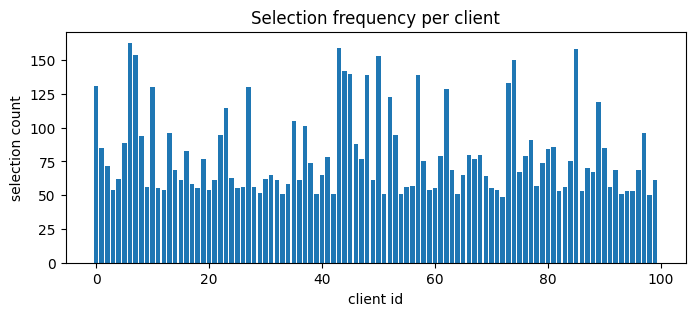

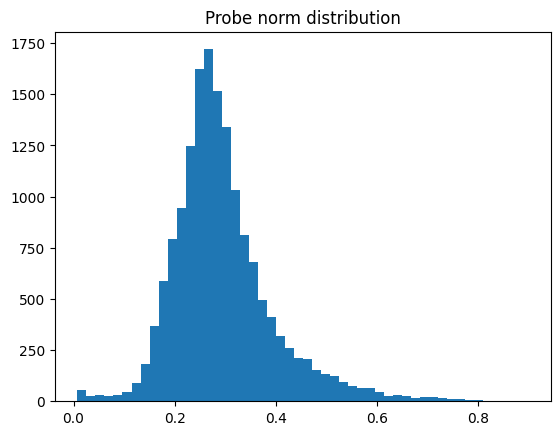

test acc mean: 0.42789999999999995 min: 0.07 max: 0.85


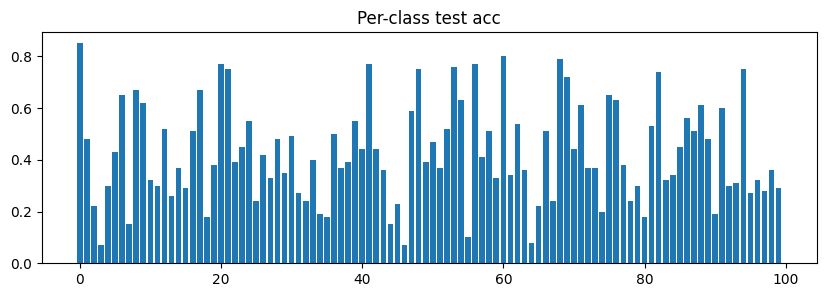

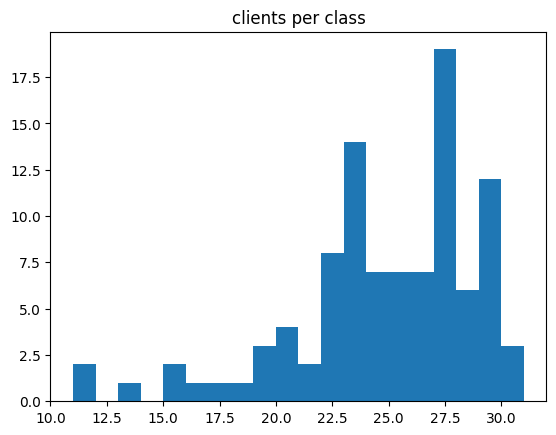

In [ ]:
import numpy as np, matplotlib.pyplot as plt
# selected_history is list of lists (you already collect it)
flat = [cid for round_sel in selected_history for cid in round_sel]
counts = np.bincount(flat, minlength=K)
plt.figure(figsize=(8,3))
plt.bar(np.arange(K), counts)
plt.xlabel('client id'); plt.ylabel('selection count'); plt.title('Selection frequency per client')
plt.show()


# probe_history is list of lists of probe_norms values
all_probes = np.concatenate([np.array(p) for p in probe_history if len(p)>0])
plt.hist(all_probes, bins=50)
plt.title("Probe norm distribution")
plt.show()


# one-shot evaluation to see which classes are failing
from collections import defaultdict
model.eval()
correct_per_class = defaultdict(int)
count_per_class = defaultdict(int)
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(1).cpu().numpy()
        lbls_np = lbls.numpy()
        for p, t in zip(preds, lbls_np):
            if p == t: correct_per_class[t] += 1
            count_per_class[t] += 1

accs = [correct_per_class[i] / max(1, count_per_class[i]) for i in range(100)]
import numpy as np
print("test acc mean:", np.mean(accs), "min:", np.min(accs), "max:", np.max(accs))
plt.figure(figsize=(10,3)); plt.bar(range(100), accs); plt.title("Per-class test acc"); plt.show()



# shards is the current shards list (list of Subset)
from collections import Counter, defaultdict
label2clients = defaultdict(set)
for cid, subset in enumerate(shards):
    for idx in subset.indices:
        _, lbl = train_dataset[idx]   # assuming train_dataset is the base
        label2clients[lbl].add(cid)
cover_counts = [len(label2clients[c]) for c in range(100)]
plt.hist(cover_counts, bins=20); plt.title("clients per class"); plt.show()


In [ ]:
from collections import Counter
sel_flat = [cid for round_sel in selected_history for cid in round_sel]
freq = Counter(sel_flat)
counts = [freq.get(i,0) for i in range(K)]
import numpy as np
print("selected counts: min, max, mean, median, std:", np.min(counts), np.max(counts), np.mean(counts), np.median(counts), np.std(counts))



import numpy as np
import torch
from collections import Counter

def subset_num_classes_safe(shard, dataset=None):
    """
    Returns number of unique labels in `shard`.
    Accepts:
      - torch.utils.data.Subset (recommended)
      - sequence of indices (then `dataset` must be provided)
      - object with .indices and .dataset attributes
    """
    # Case 1: torch.utils.data.Subset or object with .indices/.dataset
    if hasattr(shard, "indices") and hasattr(shard, "dataset"):
        base_ds = shard.dataset
        indices = shard.indices
    # Case 2: plain list/ndarray of indices (user must pass dataset)
    elif isinstance(shard, (list, tuple, np.ndarray)):
        if dataset is None:
            raise ValueError("shard is a list of indices — please pass dataset=<your_dataset> to subset_num_classes_safe")
        base_ds = dataset
        indices = list(shard)
    # Case 3: maybe shard is already a Dataset (all examples) -> count on full dataset
    elif hasattr(shard, "__getitem__") and isinstance(shard, torch.utils.data.Dataset):
        base_ds = shard
        indices = list(range(len(shard)))
    else:
        raise TypeError("Unsupported shard type. Provide a Subset, a list of indices (with dataset=...), or a Dataset.")

    labs = set()
    for idx in indices:
        # some dataset implementations return (img, label) or a dict
        item = base_ds[idx]
        if isinstance(item, dict):
            lbl = item.get('label') or item.get('target') or item.get('y')
        else:
            # typical (x, y)
            lbl = item[1]
        labs.add(int(lbl))
    return len(labs)


# --- Use this to compute per-client unique-class counts for your `shards` list ---
# If `shards` are Subset objects produced by your sharder, this will work directly.
uc = [subset_num_classes_safe(s) for s in shards]

print("classes per client min,max,mean,median,std: ",
      np.min(uc), np.max(uc), np.mean(uc), np.median(uc), np.std(uc))

# Top-10 clients by number of unique classes
top10 = sorted([(i, uc_i) for i, uc_i in enumerate(uc)], key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 clients by number of unique classes:")
print("  client_id  unique_classes")
for cid, val in top10:
    print(f"{cid:10d}{val:16d}")

def eval_on_loader(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            correct += preds.eq(lbls).sum().item()
            total += lbls.size(0)
    return correct / total if total>0 else 0.0

client_local_acc = []
for i in range(K):
    acc = eval_on_loader(model, client_loaders[i])
    client_local_acc.append(acc)
print("local acc min, max, mean, med, std:", np.min(client_local_acc), np.max(client_local_acc), np.mean(client_local_acc), np.median(client_local_acc), np.std(client_local_acc))


import scipy.stats as ss
print("corr local_acc vs class_count:", ss.spearmanr(client_local_acc, uc))
print("corr local_acc vs selection_freq:", ss.spearmanr(client_local_acc, counts))



selected counts: min, max, mean, median, std: 49 163 80.0 69.0 31.295686603747807
classes per client min,max,mean,median,std:  2 49 24.38 23.0 13.898762534844606

Top 10 clients by number of unique classes:
  client_id  unique_classes
         3              49
        64              49
        98              49
        12              47
        33              47
        72              47
        93              47
        51              46
        71              46
        82              46
local acc min, max, mean, med, std: 0.19333333333333333 0.7088888888888889 0.5801333333333334 0.6044444444444445 0.09347017481660615
corr local_acc vs class_count: SignificanceResult(statistic=np.float64(0.5876237644438087), pvalue=np.float64(1.300936402480533e-10))
corr local_acc vs selection_freq: SignificanceResult(statistic=np.float64(-0.5761306910832338), pvalue=np.float64(3.5705580748097985e-10))


In [ ]:
i run it for 50 epochs and j = 2.

the best accuracy is
[sampled_uniform | J=4] Round 49/50 Time=43.4s | ProbeNorms=0.1628/0.2622/0.5245 | Local Acc=0.579±0.132 | Val Acc=0.176 | Test Acc=0.199

This is the output of the test cells
test acc mean: 0.1813 min: 0.0 max: 0.8

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load results
df = pd.read_csv('./fedavg_results.csv', names=['shard','J','round','val_acc'], header=0)

# 2) Pivot final validation accuracy per (shard,J)
final = df.groupby(['shard','J']).last().reset_index()
pivot = final.pivot(index='shard', columns='J', values='val_acc')
print("Final Validation Accuracy:")
display(pivot)

# 3) Plot convergence curves for each (shard, J)
plt.figure(figsize=(10,6))
for (shard, J), group in df.groupby(['shard','J']):
    plt.plot(group['round'], group['val_acc'], label=f"{shard}, J={J}")
plt.xlabel('Federated Round')
plt.ylabel('Validation Accuracy')
plt.title('FedAvg Convergence: IID vs Non-IID, varying J')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) (Optional) Rolling average smoothing
plt.figure(figsize=(10,6))
for (shard, J), group in df.groupby(['shard','J']):
    sm = group['val_acc'].rolling(window=50, min_periods=1).mean()
    plt.plot(group['round'], sm, label=f"{shard}, J={J}")
plt.xlabel('Federated Round')
plt.ylabel('Smoothed Validation Acc')
plt.title('Smoothed Convergence Curves')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 5) Plot data‐distribution boxplots (to verify your non-IID splits)
from collections import Counter

for key, shards in shardings.items():
    # count labels per client
    counts = [Counter([full_train[i][1] for i in subset]) for subset in shards]
    # convert to list of lists for boxplot
    per_class_counts = []
    for lbl in range(100):
        per_class_counts.append([c[lbl] for c in counts])
    plt.figure(figsize=(8,4))
    plt.boxplot(per_class_counts, whis=(5,95), showfliers=False)
    plt.title(f"Label counts per client — {key}")
    plt.xlabel("Class label")
    plt.ylabel("Examples per client")
    plt.tight_layout()
    plt.show()


In [ ]:
#ATTENZIONE!!!!
#OCCHIO A RUNNAREEEE



#utility function that deletes all checkpoints from the checkpoint folder

def clear_checkpoints(ckpt_dir):
    """
    Remove all checkpoint files in the specified dire ctory.
    """
    removed = 0
    for fname in os.listdir(ckpt_dir):
        path = os.path.join(ckpt_dir, fname)
        if os.path.isfile(path):
            os.remove(path)
            removed += 1
    print(f"[Checkpoint] Cleared {removed} files from {ckpt_dir}")


clear_checkpoints(CKPT_DIR)
clear_checkpoints(RESULTS_DIR)

In [ ]:
#if files or folder dont appear on your drive, run this, they should appear after

#!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Using CSVs: ['/content/drive/MyDrive/fl_results/rounds_betaF=0,3_epsilon=0,05_temp=0,3.csv', '/content/drive/MyDrive/fl_results/rounds_betaF=0,3_epsilon=0,05_temp=0,7.csv']
Saved: /content/drive/MyDrive/fl_results/compare_test_acc_temp.png


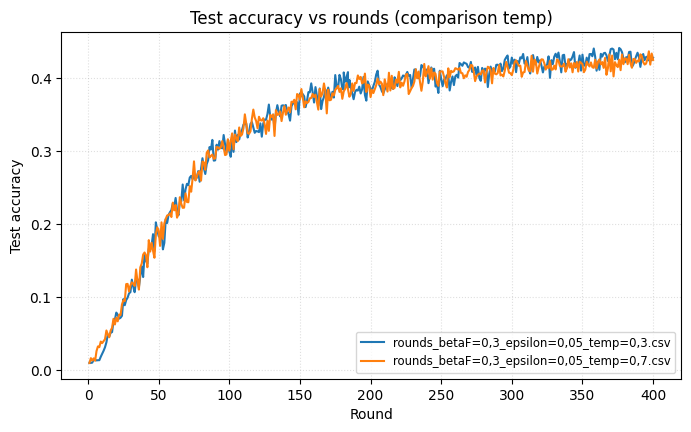

Saved: /content/drive/MyDrive/fl_results/compare_val_acc_temp.png


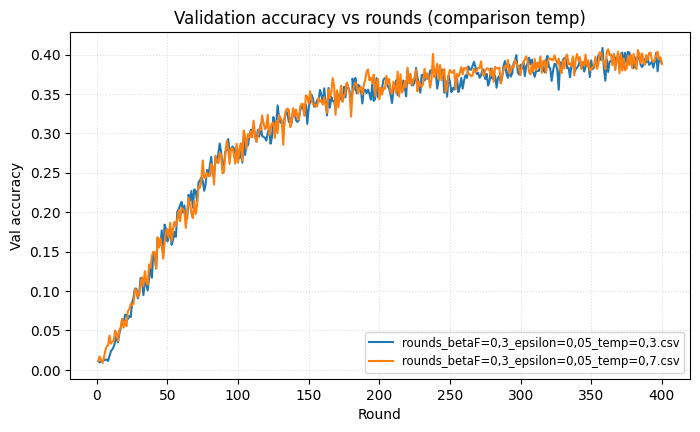

Saved: /content/drive/MyDrive/fl_results/compare_test_loss_temp.png


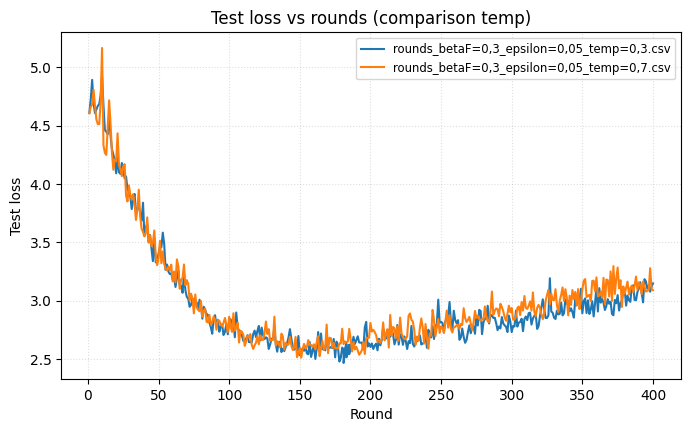

Saved: /content/drive/MyDrive/fl_results/compare_probe_mean_temp.png


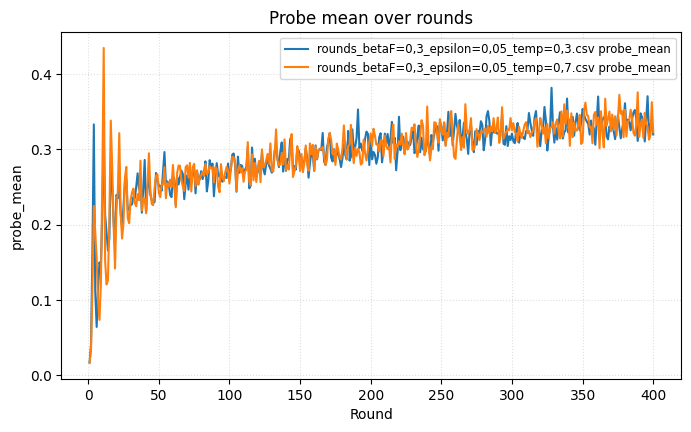

Saved: /content/drive/MyDrive/fl_results/compare_selection_mean_temp.png


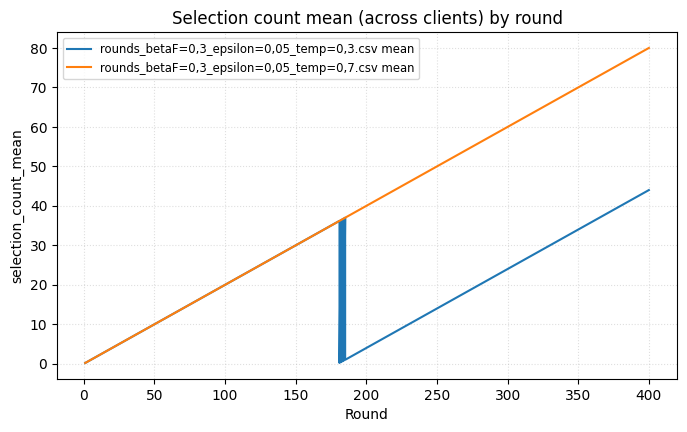

Done. Plots saved to: /content/drive/MyDrive/fl_results


In [ ]:
# ====== Utility: compare runs from CSVs (and pickles) ======
import os, json, pickle, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EDIT if your results folder is different
ARTIFACT_DIR = "/content/drive/MyDrive/fl_results"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ---------------- helpers ----------------
def load_run_csv(path):
    """Load single run CSV into DataFrame and coerce numeric columns."""
    df = pd.read_csv(path)
    # ensure round index exists and is integer
    if 'round' in df.columns:
        df['round'] = df['round'].astype(int)
        df = df.sort_values('round').reset_index(drop=True)
    # Convert JSON-like columns to python objects if present
    if 'selected_ids_json' in df.columns:
        def try_parse(x):
            if pd.isna(x) or x == "":
                return []
            try:
                return json.loads(x)
            except Exception:
                try:
                    return json.loads(str(x).replace("'", '"'))
                except:
                    return str(x)
        df['selected_ids'] = df['selected_ids_json'].apply(try_parse)
    return df

def find_pickles_for_run(run_id):
    """Return path of arrays pickle for run_id if present in ARTIFACT_DIR."""
    p = os.path.join(ARTIFACT_DIR, f"{run_id}_arrays.pkl")
    return p if os.path.exists(p) else None

def load_run_arrays(run_id):
    """Load the *_arrays.pkl file (selected_history, selection_count, ...) if present."""
    p = find_pickles_for_run(run_id)
    if p is None:
        return None
    with open(p, 'rb') as f:
        return pickle.load(f)

# ---------------- top-level loader ----------------
def load_runs(csv_paths):
    """
    Load a list of CSV paths and return dict: run_key -> {df, run_id, csv_path, arrays (optional)}
    run_key: use run_id column if present (first row), otherwise filename.
    """
    runs = {}
    for p in csv_paths:
        df = load_run_csv(p)
        # pick run id
        run_id = None
        if 'run_id' in df.columns and df['run_id'].notna().any():
            run_id = df.loc[df['run_id'].notna(), 'run_id'].iloc[0]
        if run_id is None:
            run_id = os.path.splitext(os.path.basename(p))[0]
        arrays = load_run_arrays(run_id)
        key = run_id
        runs[key] = {'df': df, 'run_id': run_id, 'csv_path': p, 'arrays': arrays}
    return runs

# ---------------- plotting helpers ----------------
def plot_metric_across_runs(runs, metric='test_acc', ylabel=None, title=None, save_name=None):
    """
    Plot metric vs round for all runs in `runs` dict.
    runs: dict returned by load_runs
    metric: column name present in CSVs (e.g. 'test_acc', 'val_acc', 'test_loss', 'probe_mean', ...)
    """
    plt.figure(figsize=(8,4.5))
    for k, v in runs.items():
        df = v['df']
        if metric not in df.columns:
            print(f"[skip] {metric} not in {k}")
            continue
        rounds = df['round'].values
        y = df[metric].astype(float).values
        # Use the filename for the label
        label = os.path.basename(v['csv_path'])
        plt.plot(rounds, y, label=label)
        # if local_std present, optionally shade
        std_col = metric.replace('_acc','_std') if metric.endswith('_acc') else None
        if std_col and std_col in df.columns:
            std = df[std_col].astype(float).values
            plt.fill_between(rounds, y-std, y+std, alpha=0.15)
    plt.xlabel("Round")
    plt.ylabel(ylabel or metric)
    plt.title(title or metric)
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(fontsize='small', loc='best')
    if save_name:
        out = os.path.join(ARTIFACT_DIR, save_name)
        plt.savefig(out, bbox_inches='tight', dpi=200)
        print("Saved:", out)
    plt.show()

def plot_probe_stats(runs, save_name=None):
    """Plot probe_min/mean/max vs rounds for each run (if present)."""
    plt.figure(figsize=(8,4.5))
    for k,v in runs.items():
        df = v['df']
        if 'probe_mean' not in df.columns:
            print(f"[skip] probe_mean not in {k}")
            continue
        rounds = df['round'].values
        # Use the filename for the label
        label = os.path.basename(v['csv_path'])
        plt.plot(rounds, df['probe_mean'].astype(float).values, label=f"{label} probe_mean")
    plt.xlabel("Round")
    plt.ylabel("probe_mean")
    plt.title("Probe mean over rounds")
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(fontsize='small')
    if save_name:
        out = os.path.join(ARTIFACT_DIR, save_name)
        plt.savefig(out, bbox_inches='tight', dpi=200)
        print("Saved:", out)
    plt.show()

def plot_selection_summary(runs, save_name=None):
    """Plot selection_count_mean and selection_count_std vs round if available."""
    plt.figure(figsize=(8,4.5))
    for k,v in runs.items():
        df = v['df']
        if 'selection_count_mean' in df.columns:
            # Use the filename for the label
            label = os.path.basename(v['csv_path'])
            plt.plot(df['round'].values, df['selection_count_mean'].astype(float).values, label=f"{label} mean")
    plt.xlabel("Round")
    plt.ylabel("selection_count_mean")
    plt.title("Selection count mean (across clients) by round")
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(fontsize='small')
    if save_name:
        out = os.path.join(ARTIFACT_DIR, save_name)
        plt.savefig(out, bbox_inches='tight', dpi=200)
        print("Saved:", out)
    plt.show()



# ---------------- convenience: find CSVs by pattern ----------------
def collect_csvs_from_dir(artifact_dir=ARTIFACT_DIR, pattern="rounds_*.csv"):
    paths = sorted(glob.glob(os.path.join(artifact_dir, pattern)))
    return paths

# ---------------- Example usage ----------------
# 1) collect some CSVs (edit as needed)
csvs = collect_csvs_from_dir(ARTIFACT_DIR, pattern="rounds_*.csv")[:3]   # pick first 3 found
print("Using CSVs:", csvs)

# 2) load them
runs = load_runs(csvs)

# 3) quick plots comparing runs
plot_metric_across_runs(runs, metric='test_acc', ylabel='Test accuracy', title='Test accuracy vs rounds (comparison temp)', save_name='compare_test_acc_temp.png')
plot_metric_across_runs(runs, metric='val_acc', ylabel='Val accuracy', title='Validation accuracy vs rounds (comparison temp)', save_name='compare_val_acc_temp.png')
plot_metric_across_runs(runs, metric='test_loss', ylabel='Test loss', title='Test loss vs rounds (comparison temp)', save_name='compare_test_loss_temp.png')

# 4) probe & selection plots
plot_probe_stats(runs, save_name='compare_probe_mean_temp.png')
plot_selection_summary(runs, save_name='compare_selection_mean_temp.png')



print("Done. Plots saved to:", ARTIFACT_DIR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found CSVs: ['/content/drive/MyDrive/fl_results/rounds_20250901-143811_J4_C0.2_LR0.01_seed42_4c016f.csv', '/content/drive/MyDrive/fl_results/rounds_20250901-144317_J4_C0.2_LR0.01_seed42_8eeaa0.csv', '/content/drive/MyDrive/fl_results/rounds_20250901-164348_J4_C0.2_LR0.01_seed42_389f4a.csv']
Saved: /content/drive/MyDrive/fl_results/20250901-164348_J4_C0.2_LR0.01_seed42_389f4a_selection_count_hist.png


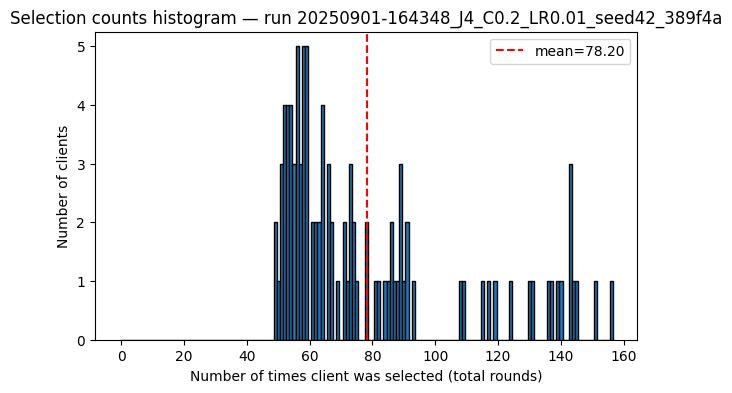

Note: per-client accuracy was approximated by distributing per-round local_mean across selected clients.
Saved: /content/drive/MyDrive/fl_results/20250901-164348_J4_C0.2_LR0.01_seed42_389f4a_per_client_acc_hist.png


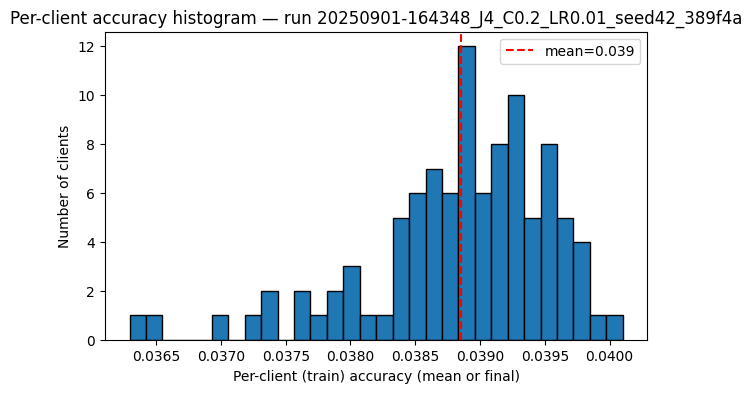

Per-client loss not found in arrays.
Done. Generated histograms for: 20250901-164348_J4_C0.2_LR0.01_seed42_389f4a


Auto-selected CSV: /content/drive/MyDrive/fl_results/rounds_betaF=0,3_epsilon=0,05_temp=0,7.csv
Selection counts summary: min, mean, median, max, std = 98 161.0 139.0 345 65.3938835060283
Saved PNG: /content/drive/MyDrive/fl_results/client_selection_counts_rounds_betaF=0,3_epsilon=0,05_temp=0,7.png


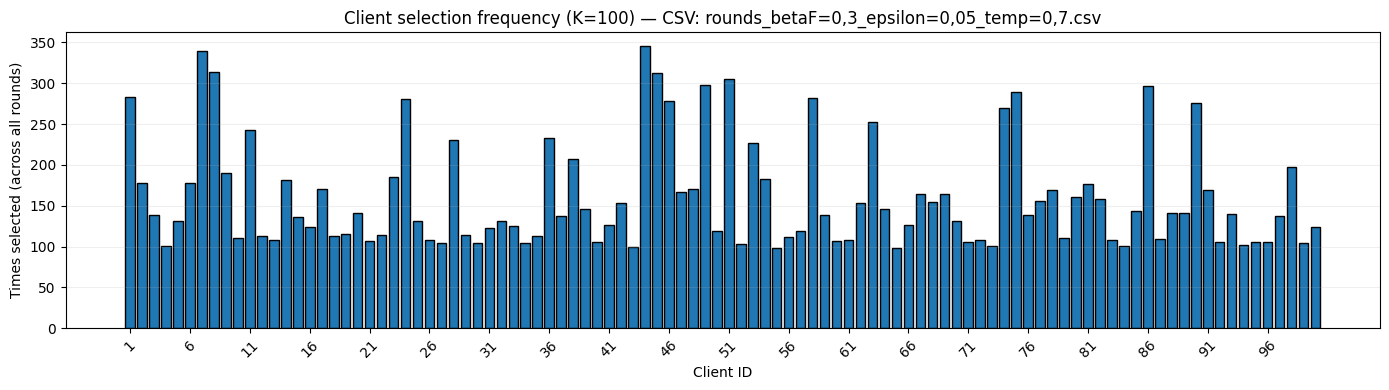

Saved selection counts CSV: /content/drive/MyDrive/fl_results/client_selection_counts_rounds_betaF=0,3_epsilon=0,05_temp=0,7.csv


In [ ]:
# === Plot selection counts per client (x axis = client id 1..K) ===
import os, glob, json, re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== USER CONFIG ==========
ARTIFACT_DIR = "/content/drive/MyDrive/fl_results"   # change if your CSVs are elsewhere
csv_path = None   # set to a single csv path (string) OR None to auto-pick latest rounds_*.csv in ARTIFACT_DIR
K = 100           # total number of clients in your experiment
one_indexed_display = True  # show x-axis as 1..K (True) even if stored ids are 0..K-1
tick_step = 5     # show x tick label every this many clients (adjust for readability)
save_png = True
# ==================================

os.makedirs(ARTIFACT_DIR, exist_ok=True)

def parse_selected_ids_cell(cell):
    """Robust parse for selected_ids_json-like cells into list[int]."""
    if cell is None:
        return []
    if isinstance(cell, (list, tuple)):
        return [int(x) for x in cell]
    s = str(cell).strip()
    if s == "" or s.lower() == "nan":
        return []
    # try json.loads first
    try:
        parsed = json.loads(s)
        if isinstance(parsed, list):
            return [int(x) for x in parsed]
        if isinstance(parsed, (int, float)):
            return [int(parsed)]
    except Exception:
        pass
    # try replacing single quotes then json
    try:
        s2 = s.replace("'", '"')
        parsed = json.loads(s2)
        if isinstance(parsed, list):
            return [int(x) for x in parsed]
    except Exception:
        pass
    # fallback: regex integers
    ints = re.findall(r"-?\d+", s)
    if len(ints) > 0:
        return [int(x) for x in ints]
    return []

def collect_csvs(artifact_dir=ARTIFACT_DIR, pattern="rounds_*.csv"):
    files = sorted(glob.glob(os.path.join(artifact_dir, pattern)))
    return files

# pick CSV(s)
if csv_path is None:
    csv_list = collect_csvs(ARTIFACT_DIR)
    if len(csv_list) == 0:
        raise FileNotFoundError(f"No CSV files matching rounds_*.csv found in {ARTIFACT_DIR}")
    # default: pick the latest one. Change if you want multiple.
    csv_path = csv_list[-1]
    print("Auto-selected CSV:", csv_path)
else:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    csv_list = [csv_path]

# read & parse
df = pd.concat([pd.read_csv(p) for p in csv_list], ignore_index=True, sort=False)
if 'selected_ids_json' not in df.columns:
    raise KeyError("CSV must contain column 'selected_ids_json'")

# parse each row and count selections
counter = Counter()
for cell in df['selected_ids_json'].fillna(""):
    ids = parse_selected_ids_cell(cell)
    for cid in ids:
        counter[int(cid)] += 1

# build counts array for clients 0..K-1 (or 1..K depending on storage)
counts = np.zeros(K, dtype=int)
for cid, c in counter.items():
    # ignore out-of-range ids, but warn if many
    if 0 <= cid < K:
        counts[cid] = c
    elif 1 <= cid <= K and 0 <= (cid-1) < K:
        # in case CSV used 1-based ids, place into counts[cid-1]
        counts[cid-1] = c
    else:
        # out of expected range; skip but you may want to inspect
        pass

# Summary stats
print("Selection counts summary: min, mean, median, max, std =",
      int(counts.min()), float(counts.mean()), float(np.median(counts)), int(counts.max()), float(counts.std()))

# x labels (display 1..K)
if one_indexed_display:
    x_labels = np.arange(1, K+1)
else:
    x_labels = np.arange(0, K)

# Plot bar chart with client ids on x axis (ordered 1..K)
plt.figure(figsize=(14,4))
x = np.arange(K)
plt.bar(x, counts, edgecolor='black')
# reduce tick clutter: show tick every tick_step
ticks = np.arange(0, K, tick_step)
tick_labels = [str(int(x_labels[i])) for i in ticks]
plt.xticks(ticks, tick_labels, rotation=45)
plt.xlabel("Client ID")
plt.ylabel("Times selected (across all rounds)")
plt.title(f"Client selection frequency (K={K}) — CSV: {os.path.basename(csv_path)}")
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()

if save_png:
    out_png = os.path.join(ARTIFACT_DIR, f"client_selection_counts_{os.path.basename(csv_path).replace('.csv','')}.png")
    plt.savefig(out_png, dpi=200, bbox_inches='tight')
    print("Saved PNG:", out_png)

plt.show()

# also save numeric counts as a CSV for easy inclusion in paper/tables
counts_df = pd.DataFrame({
    'client_id': x_labels,
    'selected_count': counts
})
out_counts_csv = os.path.join(ARTIFACT_DIR, f"client_selection_counts_{os.path.basename(csv_path).replace('.csv','')}.csv")
counts_df.to_csv(out_counts_csv, index=False)
print("Saved selection counts CSV:", out_counts_csv)
